In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dateutil.parser
import matplotlib.patches as mpatches
import re
import operator

%matplotlib inline

## Load the Data

In [2]:
first_part = "2015_data/2015"
second_part = "-citibike-tripdata.csv"
months = ['01','02','03','04','05','06','07','08','09','10','11','12']

In [3]:
citi = pd.DataFrame()
for i in months:
    file = first_part+i+second_part
    data = pd.read_csv(file)
    citi = pd.concat([citi,data])

In [4]:
citi.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1


In [5]:
citi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9937969 entries, 0 to 804124
Data columns (total 15 columns):
tripduration               int64
starttime                  object
stoptime                   object
start station id           int64
start station name         object
start station latitude     float64
start station longitude    float64
end station id             int64
end station name           object
end station latitude       float64
end station longitude      float64
bikeid                     int64
usertype                   object
birth year                 float64
gender                     int64
dtypes: float64(5), int64(5), object(5)
memory usage: 1.2+ GB


In [6]:
citi.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

In [7]:
citi["tripduration"].describe()

count    9.937969e+06
mean     9.680877e+02
std      7.609485e+03
min      6.000000e+01
25%      3.890000e+02
50%      6.290000e+02
75%      1.049000e+03
max      5.864661e+06
Name: tripduration, dtype: float64

## The mean is much higher than the median which indicates that there are rows that dramatically influences the data's statistics

In [8]:
len(citi) ## These are the number of trips recorded in the year 2015

9937969

/home/jtoro/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


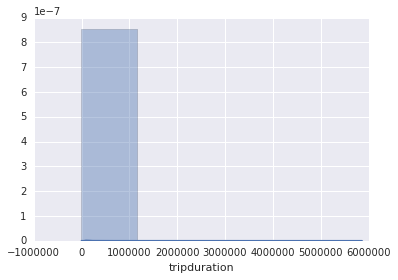

In [9]:
sns.distplot(citi['tripduration'],bins = 5);

## Trips that last millions of seconds are impossible considering that there are only 86400 seconds in a week. Based on this distribution plot we can see that there are outliers that skews the entire graph. I will now see which observations I should delete from the data set based on how long the trip duration is.

In [10]:
outlier = citi["tripduration"].quantile(.995)

In [11]:
7203/60 
# 99.5% of the trips in the data are less than two hours. 
##I will delete all observations where the trip duration is longer than two hours

120.05

In [12]:
citi = citi.ix[citi['tripduration'] <= outlier]

In [13]:
len(citi) ## We are left with this many rows after deleting the outliers

9888279

/home/jtoro/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


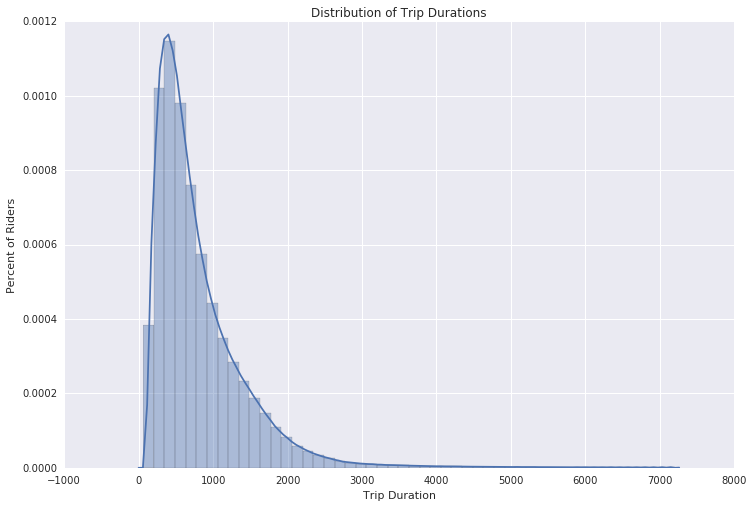

In [14]:
plt.figure(figsize = (12,8))
sns.distplot(citi['tripduration'])
plt.title("Distribution of Trip Durations")
plt.xlabel("Trip Duration")
plt.ylabel("Percent of Riders");

## We can see that most trips are less than 1000 seconds which is around 17 minutes. There are a few that last more than 30 minutes. 

In [15]:
citi['tripduration'].describe()

count    9.888279e+06
mean     8.138695e+02
std      6.662093e+02
min      6.000000e+01
25%      3.880000e+02
50%      6.260000e+02
75%      1.040000e+03
max      7.203000e+03
Name: tripduration, dtype: float64

In [16]:
citi.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

In [17]:
citi["starttime"].head()

0    1/1/2015 0:01
1    1/1/2015 0:02
2    1/1/2015 0:04
3    1/1/2015 0:04
4    1/1/2015 0:05
Name: starttime, dtype: object

In [18]:
citi["stoptime"].head()

0    1/1/2015 0:24
1    1/1/2015 0:08
2    1/1/2015 0:10
3    1/1/2015 0:07
4    1/1/2015 0:21
Name: stoptime, dtype: object

In [19]:
## function to get the hour of day when the bike was taken
def get_hour(time):
    regex = re.compile(' [^:]*')
    x = re.search(regex,time)
    hour = x.group(0)
    hour = hour[1:]
    return int(hour)

In [20]:
citi["hour"] = citi["starttime"].apply(get_hour)

In [21]:
total_by_hour = [0]*24

In [22]:
for i in citi['hour']:
    total_by_hour[i] += 1

In [23]:
total_by_hour

[94601,
 53367,
 31048,
 19255,
 17830,
 53780,
 213374,
 445845,
 794074,
 638031,
 438408,
 459397,
 532470,
 557443,
 575856,
 604556,
 702723,
 967084,
 924033,
 646250,
 428099,
 302944,
 230380,
 157431]

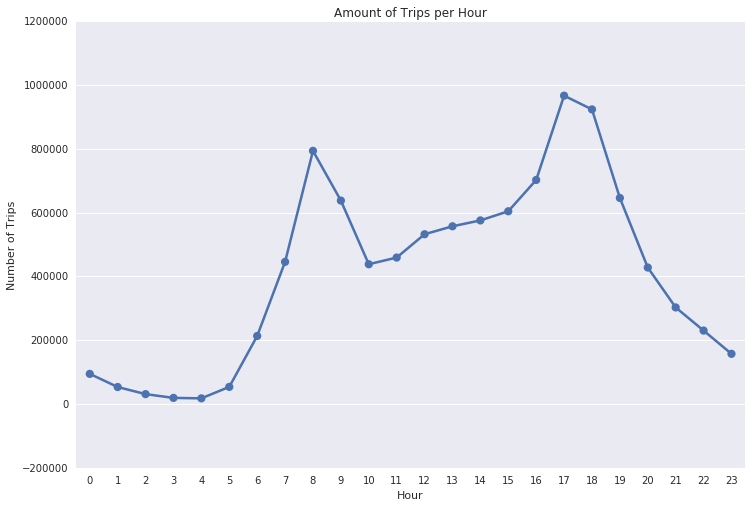

In [24]:
sns.set_style("darkgrid")
plt.figure(figsize=(12,8))
sns.pointplot(x = list(range(24)), y = total_by_hour, scale = .8)
plt.title("Amount of Trips per Hour")
plt.xlabel("Hour")
plt.ylabel("Number of Trips")
plt.show();

## Activity dies down at night for obvious reasons. The most activity occurs during rush hour when people commute to work.

In [26]:
#Put all the dates of 2015 in a list
days = list(range(1,32))
months = list(range(1,13))

all_days = []
for m in months:
    for d in days:
        all_days.append(str(m)+'/'+str(d)+'/'+str(2015))

In [27]:
invalid_days = ['2/29/2015','2/30/2015','2/31/2015','4/31/2015','6/31/2015','9/31/2015','11/31/2015']

In [28]:
## Remove invalid days like the ones above
indexes_to_remove = []
for i in invalid_days:
    indexes_to_remove.append(all_days.index(i))

In [29]:
for i in indexes_to_remove[::-1]:
    all_days.pop(i)

In [30]:
## The first day of 2015 is Thursday so the pattern to follow is weekday, weekday, weekend,
## weekend, weekday, weekday, weekday

weekend_pattern = ["0", "0", "1", "1", "0", "0", "0"]
## Where weekday = 0 and weekend = 1
all_year_pattern = weekend_pattern * 52
all_year_pattern = all_year_pattern + ["0"]

In [31]:
len(all_year_pattern)

365

In [32]:
date_weekday = {}
for a, b in zip(all_days, all_year_pattern):
    date_weekday[a] = b

In [33]:
## Function to determine whether the bike was taken on a weekend or weekday. 0 means weekday, 1 means weekend
def is_weekend(date):
    separate = date.split(" ")
    return int(date_weekday[separate[0]])

In [34]:
citi["is_weekend"] = citi["starttime"].apply(is_weekend)

In [35]:
citi.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,hour,is_weekend
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2,0,0
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1,0,0
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1,0,0
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1,0,0
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1,0,0


In [36]:
weekday_by_hour = [0] * 24
weekend_by_hour = [0] * 24
for a, b in zip(citi["hour"],citi["is_weekend"]):
    if b == 0:
        weekday_by_hour[a] += 1
    else:
        weekend_by_hour[a] += 1

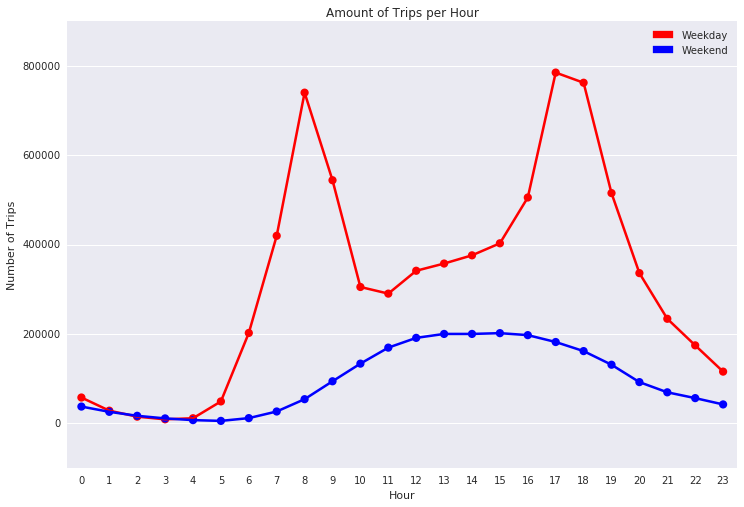

In [37]:
sns.set_style("darkgrid")
plt.figure(figsize=(12,8))
sns.pointplot(x = list(range(24)), y = weekday_by_hour, scale = .8, color = 'red')
sns.pointplot(x = list(range(24)), y = weekend_by_hour, scale = .8, color = "blue")
red_patch = mpatches.Patch(color='red', label='Weekday')
blue_patch = mpatches.Patch(color='blue', label='Weekend')
plt.legend(handles = [red_patch,blue_patch])
plt.title("Amount of Trips per Hour")
plt.xlabel("Hour")
plt.ylabel("Number of Trips")
plt.show();

## Activity is the highest during the weekdays due to more people coming into the city.

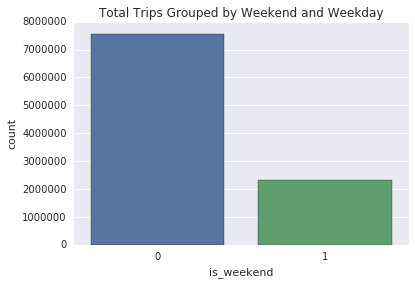

In [38]:
sns.countplot(x = "is_weekend", data = citi)
plt.title("Total Trips Grouped by Weekend and Weekday");

In [39]:
citi.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender', 'hour', 'is_weekend'],
      dtype='object')

In [40]:
## Function to determine which season the bike was taken out
def seasons(date):
    date = date.split('/')
    month = int(date[0])
    
    winter = [1,2,3]
    spring = [4,5,6]
    summer = [7,8,9]
    fall = [10,11,12]
    
    if month in winter:
        return 1
    elif month in spring:
        return 2
    elif month in summer:
        return 3
    else:
        return 4

In [41]:
citi["season"] = citi['starttime'].apply(seasons)

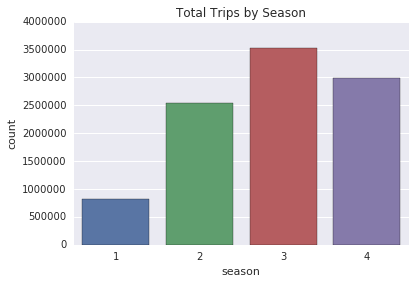

In [42]:
sns.countplot(x = "season", data = citi)
plt.title("Total Trips by Season");

## The most activity occurs during the summer. During the winter activity dies down significantly due to it being too cold

In [43]:
winter_by_hour = [0] * 24
spring_by_hour = [0] * 24
summer_by_hour = [0] * 24
fall_by_hour = [0] * 24

for a, b in zip(citi["hour"],citi["season"]):
    if b == 1:
        winter_by_hour[a] += 1
    elif b == 2:
        spring_by_hour[a] += 1
    elif b == 3:
        summer_by_hour[a] += 1
    else:
        fall_by_hour[a] += 1

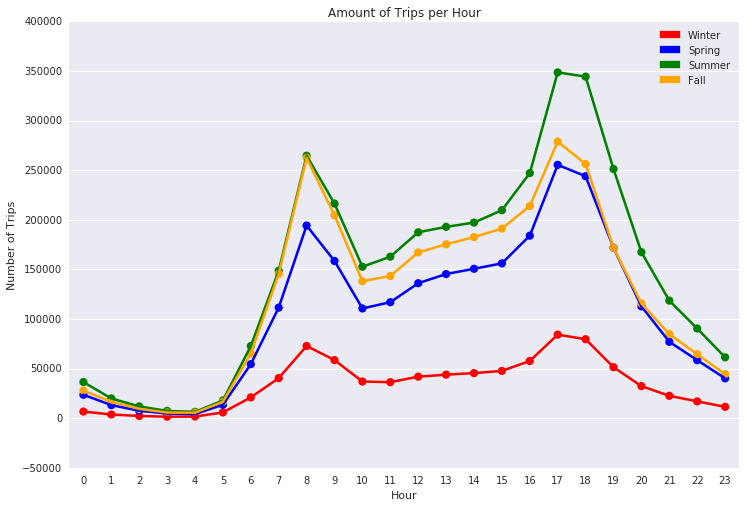

In [44]:
sns.set_style("darkgrid")
plt.figure(figsize=(12,8))
sns.pointplot(x = list(range(24)), y = winter_by_hour, scale = .8, color = 'red')
sns.pointplot(x = list(range(24)), y = spring_by_hour, scale = .8, color = "blue")
sns.pointplot(x = list(range(24)), y = summer_by_hour, scale = .8, color = "green")
sns.pointplot(x = list(range(24)), y = fall_by_hour, scale = .8, color = "orange")
red_patch = mpatches.Patch(color='red', label='Winter')
blue_patch = mpatches.Patch(color='blue', label='Spring')
green_patch = mpatches.Patch(color = "green", label = "Summer")
orange_patch = mpatches.Patch(color = "orange", label = "Fall")
plt.legend(handles = [red_patch,blue_patch, green_patch, orange_patch])
plt.title("Amount of Trips per Hour")
plt.xlabel("Hour")
plt.ylabel("Number of Trips")
plt.show();

In [45]:
def month(date):
    date = date.split("/")
    return int(date[0])

In [46]:
citi["month"] = citi["starttime"].apply(month)

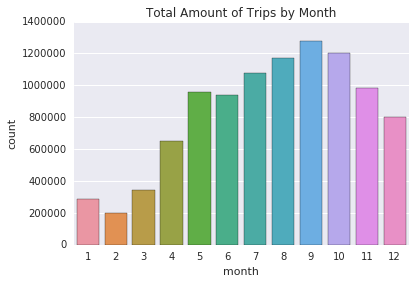

In [47]:
sns.countplot(x = 'month', data = citi)
plt.title("Total Amount of Trips by Month");

## I want to see if how the riding behavior changes based on the rider's generation. The following function creates a new columns based on the rider's generation which are Traditionalists, Baby boomers, Generation x, Millennials, and Centennials

In [48]:
citi["birth year"].dropna().describe()

count    8.608416e+06
mean     1.976556e+03
std      1.156768e+01
min      1.885000e+03
25%      1.969000e+03
50%      1.979000e+03
75%      1.986000e+03
max      1.999000e+03
Name: birth year, dtype: float64

In [49]:
def generation(year):
    if year <= 1945:
        return 1 #traditionalists born before 1945
    elif year <= 1964:
        return 2 #baby boomers born between 1946 and 1964
    elif year <= 1976:
        return 3 # generation x born between 1965 and 1976
    elif year <= 1995:
        return 4 # millennials born between 1995 and 1977
    elif year <= 2014:
        return 5 # centennials born between now and 1996
    else:
        return 6 # birth year not available

In [50]:
citi["generation"] = citi["birth year"].apply(generation)

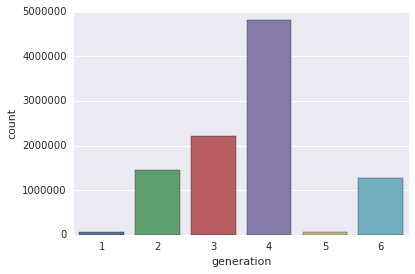

In [51]:
sns.countplot(x = 'generation', data = citi);

## Millenials have a much higher representation than other generations

In [52]:
traditionalists_by_hour = [0] * 24
baby_boomers_by_hour = [0] * 24
generation_x_by_hour = [0] * 24
millenials_by_hour = [0] * 24
centennials_by_hour = [0] * 24
nan_by_hour = [0] * 24

for a, b in zip(citi["hour"],citi["generation"]):
    if b == 1:
        traditionalists_by_hour[a] += 1
    elif b == 2:
        baby_boomers_by_hour[a] += 1
    elif b == 3:
        generation_x_by_hour[a] += 1
    elif b == 4:
        millenials_by_hour[a] += 1
    elif b == 5:
        centennials_by_hour[a] += 1
    else:
        nan_by_hour[a] += 1

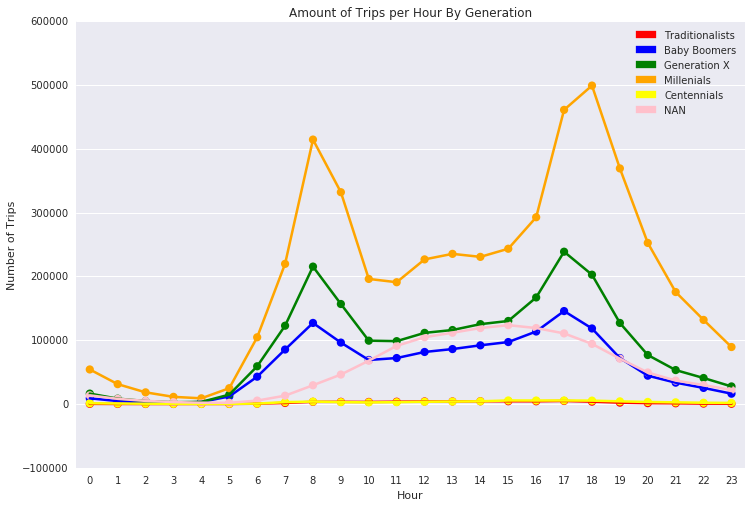

In [53]:
sns.set_style("darkgrid")
plt.figure(figsize=(12,8))
sns.pointplot(x = list(range(24)), y = traditionalists_by_hour, scale = .8, color = 'red')
sns.pointplot(x = list(range(24)), y = baby_boomers_by_hour, scale = .8, color = "blue")
sns.pointplot(x = list(range(24)), y = generation_x_by_hour, scale = .8, color = "green")
sns.pointplot(x = list(range(24)), y = millenials_by_hour, scale = .8, color = "orange")
sns.pointplot(x = list(range(24)), y = centennials_by_hour, scale = .8, color = "yellow")
sns.pointplot(x = list(range(24)), y = nan_by_hour, scale = .8, color = "pink")
red_patch = mpatches.Patch(color='red', label='Traditionalists')
blue_patch = mpatches.Patch(color='blue', label='Baby Boomers')
green_patch = mpatches.Patch(color = "green", label = "Generation X")
orange_patch = mpatches.Patch(color = "orange", label = "Millenials")
yellow_patch = mpatches.Patch(color = "yellow", label = "Centennials")
pink_patch = mpatches.Patch(color = "pink", label = "NAN")
plt.legend(handles = [red_patch,blue_patch, green_patch, orange_patch, yellow_patch, pink_patch])
plt.title("Amount of Trips per Hour By Generation")
plt.xlabel("Hour")
plt.ylabel("Number of Trips")
plt.show();

In [54]:
citi.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender', 'hour', 'is_weekend', 'season', 'month',
       'generation'],
      dtype='object')

In [55]:
end_station = {}
for i in citi["end station name"]:
    if i not in end_station:
        end_station[i] = 1
    else:
        end_station[i] += 1

In [56]:
sorted_end_station = sorted(end_station.items(), key=operator.itemgetter(1), reverse = True)

In [65]:
sorted_end_station[:10] #most popular destinations

[('Lafayette St & E 8 St', 96113),
 ('Pershing Square North', 95411),
 ('E 17 St & Broadway', 90058),
 ('W 21 St & 6 Ave', 87712),
 ('8 Ave & W 31 St', 82999),
 ('West St & Chambers St', 81411),
 ('Broadway & E 14 St', 74044),
 ('W 41 St & 8 Ave', 69632),
 ('Cleveland Pl & Spring St', 69399),
 ('Greenwich Ave & 8 Ave', 69261)]

In [58]:
start_station = {}
for i in citi["start station name"]:
    if i not in start_station:
        start_station[i] = 1
    else:
        start_station[i] += 1

In [59]:
sorted_start_station = sorted(start_station.items(), key=operator.itemgetter(1), reverse = True)

In [64]:
sorted_start_station[:10] # most popular starting points

[('Pershing Square North', 104401),
 ('8 Ave & W 31 St', 100440),
 ('Lafayette St & E 8 St', 95599),
 ('W 21 St & 6 Ave', 86903),
 ('E 17 St & Broadway', 85814),
 ('West St & Chambers St', 78622),
 ('Broadway & E 14 St', 73464),
 ('Cleveland Pl & Spring St', 70077),
 ('Greenwich Ave & 8 Ave', 67704),
 ('Broadway & E 22 St', 67289)]

In [61]:
citi["bikeid"].mode()

0    22123
dtype: int64

In [62]:
bike_22123 = citi[citi["bikeid"] == 22123]

In [63]:
bike_22123.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,hour,is_weekend,season,month,generation
101401,951,7/4/2015 08:00:06,7/4/2015 08:15:57,520,W 52 St & 5 Ave,40.759923,-73.976485,497,E 17 St & Broadway,40.737050,-73.990093,22123,Subscriber,1956.0,1,8,1,3,7,2
102431,839,7/4/2015 09:49:05,7/4/2015 10:03:04,497,E 17 St & Broadway,40.737050,-73.990093,491,E 24 St & Park Ave S,40.740964,-73.986022,22123,Customer,NaN,0,9,1,3,7,6
102753,2415,7/4/2015 10:10:23,7/4/2015 10:50:38,491,E 24 St & Park Ave S,40.740964,-73.986022,524,W 43 St & 6 Ave,40.755273,-73.983169,22123,Customer,NaN,0,10,1,3,7,6
103953,736,7/4/2015 11:08:18,7/4/2015 11:20:35,524,W 43 St & 6 Ave,40.755273,-73.983169,290,2 Ave & E 58 St,40.760203,-73.964785,22123,Subscriber,1983.0,1,11,1,3,7,4
104530,431,7/4/2015 11:31:32,7/4/2015 11:38:43,290,2 Ave & E 58 St,40.760203,-73.964785,507,E 25 St & 2 Ave,40.739126,-73.979738,22123,Subscriber,1959.0,2,11,1,3,7,2


In [66]:
new_index = list(range(len(bike_22123)))

In [68]:
## The most used bike of 2015
bike_22123 = bike_22123.reset_index()

In [73]:
bike_22123 = bike_22123[bike_22123.columns[1:]]

In [97]:
compare = 1
different_start_end = []
for end in bike_22123["end station name"][:1990]:
        if end != bike_22123["start station name"][compare]:
            different_start_end.append(compare)
            compare += 1
        else:
            compare += 1

In [108]:
different_start_end[:10]

[46, 86, 158, 166, 182, 183, 184, 368, 369, 376]

In [104]:
bike_22123[45:50]

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,hour,is_weekend,season,month,generation
45,1504,7/8/2015 09:42:07,7/8/2015 10:07:11,426,West St & Chambers St,40.717548,-74.013221,520,W 52 St & 5 Ave,40.759923,-73.976485,22123,Subscriber,1977.0,1,9,0,3,7,4
46,342,7/8/2015 11:24:09,7/8/2015 11:29:52,521,8 Ave & W 31 St,40.750967,-73.994442,525,W 34 St & 11 Ave,40.755942,-74.002116,22123,Subscriber,1978.0,1,11,0,3,7,4
47,532,7/8/2015 14:16:32,7/8/2015 14:25:25,525,W 34 St & 11 Ave,40.755942,-74.002116,530,11 Ave & W 59 St,40.771522,-73.990541,22123,Subscriber,1966.0,1,14,0,3,7,3
48,466,7/8/2015 14:54:45,7/8/2015 15:02:32,530,11 Ave & W 59 St,40.771522,-73.990541,514,12 Ave & W 40 St,40.760875,-74.002777,22123,Subscriber,1963.0,1,14,0,3,7,2
49,883,7/8/2015 15:21:29,7/8/2015 15:36:12,514,12 Ave & W 40 St,40.760875,-74.002777,489,10 Ave & W 28 St,40.750664,-74.001768,22123,Subscriber,1958.0,1,15,0,3,7,2


In [107]:
bike_22123[365:370]

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,hour,is_weekend,season,month,generation
365,2158,7/27/2015 21:54:46,7/27/2015 22:30:44,509,9 Ave & W 22 St,40.745497,-74.001971,427,Bus Slip & State St,40.701907,-74.013942,22123,Subscriber,1991.0,2,21,0,3,7,4
366,1865,7/27/2015 22:39:26,7/27/2015 23:10:32,427,Bus Slip & State St,40.701907,-74.013942,434,9 Ave & W 18 St,40.743174,-74.003664,22123,Subscriber,1991.0,2,22,0,3,7,4
367,622,7/28/2015 06:01:26,7/28/2015 06:11:48,434,9 Ave & W 18 St,40.743174,-74.003664,329,Greenwich St & N Moore St,40.720434,-74.010206,22123,Subscriber,1992.0,1,6,0,3,7,4
368,988,7/28/2015 09:53:08,7/28/2015 10:09:37,363,West Thames St,40.708347,-74.017134,128,MacDougal St & Prince St,40.727103,-74.002971,22123,Subscriber,1978.0,2,9,0,3,7,4
369,335,7/28/2015 10:24:27,7/28/2015 10:30:03,368,Carmine St & 6 Ave,40.730386,-74.002150,168,W 18 St & 6 Ave,40.739713,-73.994564,22123,Subscriber,1985.0,1,10,0,3,7,4


## The instances where the bike's next trip is different than where it was left in the previous trip can be due to either a flaw in the system or that the company is rotating bikes to help meet demand at particular stations